In [8]:
from PyHessian.pyhessian.hessian import hessian
from PyHessian.density_plot import get_esd_plot
from PyHessian.pyhessian.utils import *
from hessian_utils import *
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
# from keras.datasets import mnist
import matplotlib.pyplot as plt 
import time
import copy
import torch_optimizer as optim


# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
# How to do this?
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
%matplotlib inline


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
cuda = torch.cuda.is_available()

cpu


In [4]:
mnist_trainset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_fashion_trainset = datasets.FashionMNIST(root='./data/fashion_mnist', train=True, download=True, transform=transforms.ToTensor())
cifar_trainset = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transforms.ToTensor())
# Getting mnist test data
mnist_testset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transforms.ToTensor())
mnist_fashion_testset = datasets.FashionMNIST(root='./data/fashion_mnist', train=False, download=True, transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transforms.ToTensor())

torch.manual_seed(42)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:15<00:00, 652kB/s] 


Extracting ./data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 63.4kB/s]


Extracting ./data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:08<00:00, 202kB/s] 


Extracting ./data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Extracting ./data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw



100%|██████████| 26.4M/26.4M [00:03<00:00, 8.28MB/s]


Extracting ./data/fashion_mnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/fashion_mnist\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./data/fashion_mnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/fashion_mnist\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.27MB/s]


Extracting ./data/fashion_mnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/fashion_mnist\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Extracting ./data/fashion_mnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/fashion_mnist\FashionMNIST\raw



100%|██████████| 170M/170M [02:37<00:00, 1.08MB/s] 


Extracting ./data/cifar10\cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


In [5]:
train_X = mnist_trainset.data
train_y = mnist_trainset.targets
test_X = mnist_testset.data
test_y = mnist_testset.targets

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linear = nn.Sequential(
            nn.Linear(16*8*8, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*8*8)
        x = self.linear(x)
        return x

In [7]:
# train_X = torch.tensor(train_X).permute(0, 3, 1, 2).float()
# test_X = torch.tensor(test_X).permute(0, 3, 1, 2).float()
train_X = (train_X / 255.0).to(device)
test_X = (test_X / 255.0).to(device)
train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
test_y = torch.tensor(test_y, dtype=torch.int64).to(device)
val_x = train_X[:1000]
val_y = train_y[:1000]
x_samples = train_X[:50]
y_samples = train_y[:50]

C:\Users\DELL\AppData\Local\Temp\ipykernel_22456\3739243810.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, dtype=torch.int64).to(device)
C:\Users\DELL\AppData\Local\Temp\ipykernel_22456\3739243810.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(test_y, dtype=torch.int64).to(device)


In [ ]:
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_X[:1000], train_y[:1000]),
    batch_size=32, shuffle=True)

hessian_loader = []
for i, (x, y) in enumerate(dataloader):
    hessian_loader.append((x.to(device), y.to(device)))
    
model_SGD = Net().to(device)
model_adam = copy.deepcopy(model_SGD)
model_perp = copy.deepcopy(model_SGD)
model_para = copy.deepcopy(model_SGD)
model_shampoo = copy.deepcopy(model_SGD)
criterion = nn.CrossEntropyLoss()

optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=1e-3)
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=1e-3)
optimizer_perp = torch.optim.SGD(model_perp.parameters(), lr=1e-3)
optimizer_para = torch.optim.SGD(model_para.parameters(), lr=1e-3)

In [ ]:
epochs = 120
alpha = 0.5

train_losses_adam = []
train_losses_SGD = []
train_losses_perp = []
train_losses_para = []

perp_dots = []
para_dots = []

sgd_eigvalues = []
adam_eigvalues = []
perp_eigvalues = []
para_eigvalues = []


for epoch in range(epochs):
    model_adam.train()
    model_SGD.train()
    model_perp.train()
    model_para.train()
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer_adam.zero_grad()
        optimizer_SGD.zero_grad()
        optimizer_perp.zero_grad()
        optimizer_para.zero_grad()

        hess_adam = hessian(model_adam, criterion, data=(x_batch, y_batch), cuda=cuda)
        hess_sgd = hessian(model_SGD, criterion, data=(x_batch, y_batch), cuda=cuda)
        hess_perp = hessian(model_perp, criterion, data=(x_batch, y_batch), cuda=cuda)
        hess_para = hessian(model_para, criterion, data=(x_batch, y_batch), cuda=cuda)

        adam_eigval, adam_eigvec = hess_adam.eigenvalues(top_n=1)
        sgd_eigval, sgd_eigvec = hess_sgd.eigenvalues(top_n=1)
        perp_eigval, perp_eigvec = hess_perp.eigenvalues(top_n=1)
        para_eigval, para_eigvec = hess_para.eigenvalues(top_n=1)

        adam_eigenvalue = adam_eigval[0]
        sgd_eigenvalue = sgd_eigval[0]
        perp_eigenvalue = perp_eigval[0]
        para_eigvalue = para_eigval[0]

        adam_eigvec = adam_eigvec[0]
        sgd_eigvec = sgd_eigvec[0]
        perp_eigvec = perp_eigvec[0]
        para_eigvec = para_eigvec[0]

        output_adam = model_adam(x_batch)
        output_SGD = model_SGD(x_batch)
        output_perp = model_perp(x_batch)
        output_para = model_para(x_batch)
        
        loss_adam = criterion(output_adam, y_batch)
        loss_SGD = criterion(output_SGD, y_batch)
        loss_perp = criterion(output_perp, y_batch)
        loss_para = criterion(output_para, y_batch)
        loss_adam.backward()
        loss_SGD.backward()
        loss_perp.backward()
        loss_para.backward()

        #Normalize the eigenvectors
        perp_eigvec = normalization(perp_eigvec)
        para_eigvec = normalization(para_eigvec)
        
        #Removing the component of the gradient in the direction of the eigenvector
        perp_dot = group_product(perp_eigvec, model_perp.parameters())
        para_dot = group_product(para_eigvec, model_para.parameters())
        perp_dots.append(perp_dot.cpu().detach().numpy())
        para_dots.append(para_dot.cpu().detach().numpy())
        perp_eigvalues.append(perp_eigenvalue)
        para_eigvalues.append(para_eigvalue)
        sgd_eigvalues.append(sgd_eigenvalue)
        adam_eigvalues.append(adam_eigenvalue)
        
        for param, vec in zip(model_perp.parameters(), perp_eigvec):
            if param.grad is None:
                continue
            param.grad = alpha*param.grad + (1-alpha)*(param.grad - perp_dot* vec)
        for param, vec in zip(model_para.parameters(), para_eigvec):
            if param.grad is None:
                continue
            param.grad = alpha*param.grad + (1-alpha)*(para_dot*vec)
        
        optimizer_adam.step()
        optimizer_SGD.step()
        optimizer_perp.step()
        optimizer_para.step()
        train_losses_adam.append(loss_adam.item())
        train_losses_SGD.append(loss_SGD.item())
        train_losses_perp.append(loss_perp.item())
        train_losses_para.append(loss_para.item())
        print(f"Epoch {epoch+1}/{epochs}, Step {i+1}/{len(dataloader)}, Loss_adam: {loss_adam.item()}, Loss_SGD: {loss_SGD.item()}, Loss_perp: {loss_perp.item()}, Loss_para: {loss_para.item()}")

Epoch 1/120, Step 1/32, Loss_adam: 2.2768166065216064, Loss_SGD: 2.2768166065216064, Loss_perp: 2.2768166065216064, Loss_para: 2.2768166065216064
Epoch 1/120, Step 2/32, Loss_adam: 2.257007122039795, Loss_SGD: 2.274195909500122, Loss_perp: 2.2741968631744385, Loss_para: 2.274245023727417
Epoch 1/120, Step 3/32, Loss_adam: 2.194565534591675, Loss_SGD: 2.272629499435425, Loss_perp: 2.2726378440856934, Loss_para: 2.272878646850586
Epoch 1/120, Step 4/32, Loss_adam: 2.2395682334899902, Loss_SGD: 2.3248841762542725, Loss_perp: 2.324881076812744, Loss_para: 2.3250513076782227
Epoch 1/120, Step 5/32, Loss_adam: 2.2107741832733154, Loss_SGD: 2.2976136207580566, Loss_perp: 2.2976160049438477, Loss_para: 2.2980024814605713
Epoch 1/120, Step 6/32, Loss_adam: 2.13275408744812, Loss_SGD: 2.2664313316345215, Loss_perp: 2.2664356231689453, Loss_para: 2.2669482231140137
Epoch 1/120, Step 7/32, Loss_adam: 2.1273603439331055, Loss_SGD: 2.2767157554626465, Loss_perp: 2.2767114639282227, Loss_para: 2.2771

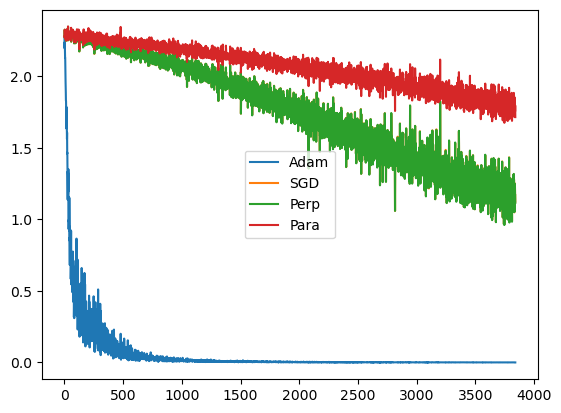

In [126]:
plt.plot(train_losses_adam, label='Adam')
plt.plot(train_losses_SGD, label='SGD')
plt.plot(train_losses_perp, label='Perp')
plt.plot(train_losses_para, label='Para')
plt.legend()
plt.show()

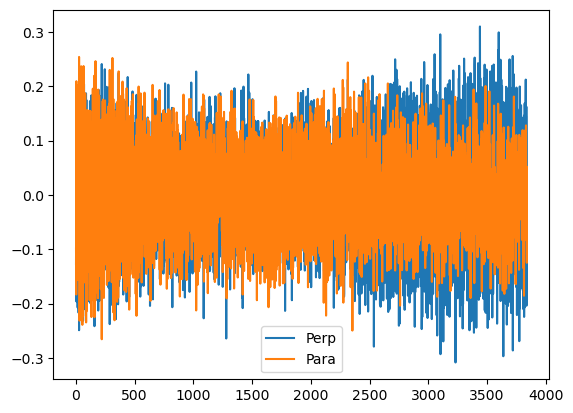

In [127]:
plt.plot(perp_dots, label='Perp')
plt.plot(para_dots, label='Para')
plt.legend()
plt.show()

In [128]:
np.mean(perp_dots), np.mean(para_dots)

(-0.0007583736, 0.0015047741)

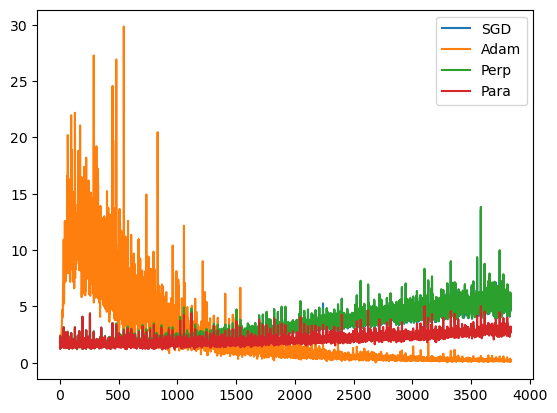

In [129]:
plt.plot(sgd_eigvalues, label='SGD')
plt.plot(adam_eigvalues, label='Adam')
plt.plot(perp_eigvalues, label='Perp')
plt.plot(para_eigvalues, label='Para')
plt.legend()